In [1]:
%load_ext autoreload
%autoreload 2
from caiman_online.run_caiman import *
from pathlib import Path
from glob import glob
import logging
import matplotlib.pyplot as plt
import numpy as np
import caiman as cm
from caiman_online.utils import make_ain
import sklearn

In [2]:
logging.basicConfig(format=
                          "%(relativeCreated)12d [%(filename)s:%(funcName)20s():%(lineno)s] [%(process)d] %(message)s",
                    # filename="/tmp/caiman.log",
                    level=logging.INFO)

In [71]:
ain_path = glob('E:/caiman_scratch/template/old/*.mat')[0] # path to mm3d file

# other custom options
x_start = 100 # remove left side artifact
x_end = 400 # stop here to remove right side artifact

# required settings if sendSetup is not being used
# these will be overwritten by sendSetup
batch_size = 5 # how many tiffs wait for to run together, in general should be > 500 frames
frame_rate = 6.36
channels = 2 
planes = 3
tiff_folder = 'E:/caiman_scratch/ori2/' # this is where the tiffs are

# motion correction
dxy = (1.5, 1.5) # spatial resolution in x and y in (um per pixel)
max_shift_um = (12., 12.) # maximum shift in um
patch_motion_xy = (100., 100.) # patch size for non-rigid correction in um

image_params = {
    'channels': channels,
    'planes': planes,
    'x_start': x_start, 
    'x_end': x_end,
    'folder': tiff_folder
}

opts = {
    # CNMF
    'fr': frame_rate,
    'p': 2,  # deconv 0 is off, 1 is slow, 2 is fast
    'nb': 3,  # background compenents -> nb: 3 for complex
    'decay_time': 1.0,  # sensor tau
    'gSig': (5, 5),  # expected half size of neurons in pixels, very important for proper component detection
    'only_init': False,  # has to be `False` when seeded CNMF is used
    'rf': None,  # half-size of the patches in pixels. Should be `None` when seeded CNMF is used.
    'ssub': 1,
    'tsub': 1,
    'do_merge': False, # new found param, testing
    'update_background_components': False,
    'merge_thr': 0.9999,
    
    
    # motion
    'gSig_filt': (7, 7), # high pass spatial filter for motioncorrection
    'nonneg_movie': True,
    'niter_rig': 1,
    'pw_rigid': False,  # piece-wise rigid flag
    'max_deviation_rigid': 3,
    'overlaps': (24, 24),
    'max_shifts': [int(a/b) for a, b in zip(max_shift_um, dxy)],
    'strides': tuple([int(a/b) for a, b in zip(patch_motion_xy, dxy)]),
    'num_frames_split': 50,    
}

In [4]:
pth = Path(tiff_folder)
movs = list(pth.glob('*.tif'))[0:30]

In [5]:
# motion worker takes: list of tiffs, plane, nchannels, planes, options
motion_worker = MCWorker(movs, 0, 2, 3, opts)
# then slice can be specified to crop out artifacts
motion_worker.xslice = slice(112, 400)

INFO:root:Changing key fr in group data from 30 to 6.36
INFO:root:Changing key decay_time in group data from 0.4 to 1.0
INFO:root:Changing key only_init in group patch from True to False
INFO:root:Changing key p in group preprocess from 2 to 1
INFO:root:Changing key nb in group init from 1 to 3
INFO:root:Changing key gSig in group init from [5, 5] to (5, 5)
INFO:root:Changing key ssub in group init from 2 to 1
INFO:root:Changing key tsub in group init from 2 to 1
INFO:root:Changing key nb in group spatial from 1 to 3
INFO:root:Changing key update_background_components in group spatial from True to False
INFO:root:Changing key p in group temporal from 2 to 1
INFO:root:Changing key nb in group temporal from 1 to 3
INFO:root:Changing key do_merge in group merging from True to False
INFO:root:Changing key merge_thr in group merging from 0.8 to 0.9999
INFO:root:Changing key gSig_filt in group motion from None to (7, 7)
INFO:root:Changing key overlaps in group motion from (32, 32) to (24, 24

In [6]:
# calling .run() does motion correction and returns the path to a memmap file
mapfile = motion_worker.run()

INFO:root:Starting local cluster.
INFO:root:Local cluster ready.
INFO:root:'load' done in 2.430s
INFO:root:Starting motion correction without provided template...
INFO:root:Creating file for motion correction "tmp_mov_mot_corr.hdf5"
INFO:root:Saving file as .\tmp_mov_mot_corr._rig__d1_512_d2_288_d3_1_order_F_frames_763_.mmap
INFO:root:** Starting parallel motion correction **
INFO:root:** Finished parallel motion correction **
INFO:root:'motion_correct' done in 14.569s
INFO:caiman.cluster:stop_cluster(): done
INFO:root:'run' done in 17.444s


In [10]:
mov  = cm.load(mapfile)
mov.play(q_max=99.5, fr=30, magnification=2)

In [8]:
Ain = make_ain(ain_path, 0, 112, 400)

Plane 0: Found 73 sources from MM3D...


In [72]:
# pass the memmap file, Ain, tiffs, plane, nchannels, nplanes, and options
caiman_worker = SeededCaimanWorker(mapfile, Ain, movs, 0, 2, 3, opts)

INFO:root:Changing key fr in group data from 30 to 6.36
INFO:root:Changing key decay_time in group data from 0.4 to 1.0
INFO:root:Changing key only_init in group patch from True to False
INFO:root:Changing key nb in group init from 1 to 3
INFO:root:Changing key gSig in group init from [5, 5] to (5, 5)
INFO:root:Changing key ssub in group init from 2 to 1
INFO:root:Changing key tsub in group init from 2 to 1
INFO:root:Changing key nb in group spatial from 1 to 3
INFO:root:Changing key update_background_components in group spatial from True to False
INFO:root:Changing key nb in group temporal from 1 to 3
INFO:root:Changing key do_merge in group merging from True to False
INFO:root:Changing key merge_thr in group merging from 0.8 to 0.9999
INFO:root:Changing key gSig_filt in group motion from None to (7, 7)
INFO:root:Changing key overlaps in group motion from (32, 32) to (24, 24)
INFO:root:Changing key max_shifts in group motion from (6, 6) to [8, 8]
INFO:root:Changing key strides in grou

In [73]:
# calling run runs seeded CNMF and returns 
result = caiman_worker.run()

INFO:root:Starting local cluster.
INFO:root:Local cluster ready.
INFO:root:Changing key n_processes in group patch from 1 to 30
INFO:root:Changing key init_batch in group online from 200 to 763
INFO:root:(763, 512, 288)
INFO:root:Changing key medw in group spatial from None to (3, 3)
INFO:root:Using 30 processes
INFO:root:Changing key n_pixels_per_process in group preprocess from None to 4915
INFO:root:Changing key n_pixels_per_process in group spatial from None to 4915
INFO:root:using 4915 pixels per process
INFO:root:using 5000 block_size_spat
INFO:root:using 5000 block_size_temp
INFO:root:preprocessing ...
INFO:root:Checking for missing data entries (NaN)
INFO:root:update spatial ...
INFO:root:Computing support of spatial components


spatial support for each components given by the user


INFO:caiman.cluster:stop_cluster(): done
INFO:root:Memory mapping
INFO:root:Updating Spatial Components using lasso lars
INFO:root:thresholding components
INFO:root:removing 2 empty spatial component(s)
INFO:root:Updating done in 2s
INFO:root:Removing created tempfiles
INFO:root:update temporal ...
INFO:root:Changing key p in group temporal from 2 to 0
INFO:root:Generating residuals
INFO:root:entering the deconvolution 
INFO:root:68 out of total 71 temporal components updated
INFO:root:71 out of total 71 temporal components updated
INFO:root:68 out of total 71 temporal components updated
INFO:root:71 out of total 71 temporal components updated
INFO:root:refinement...
INFO:root:Updating spatial ...
INFO:root:Computing support of spatial components
INFO:root:dilate in parallel...
INFO:root:Memory mapping
INFO:root:Updating Spatial Components using lasso lars
INFO:root:thresholding components
INFO:root:Updating done in 2s
INFO:root:Removing created tempfiles
INFO:root:Changing key p in gr

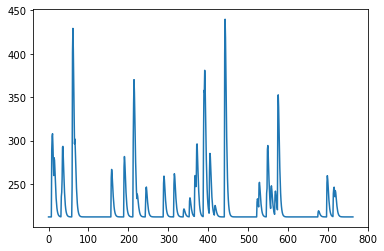

In [74]:
plt.plot(result.estimates.C[3])

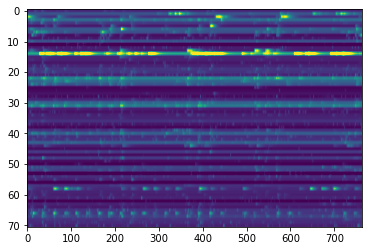

In [75]:
plt.imshow(result.estimates.C, aspect='auto', vmin=0, vmax=600)

In [76]:
c = np.array(result.estimates.C)        
c = c - c.min(axis=1).reshape(-1,1)
c = sklearn.preprocessing.scale(c, axis=1)

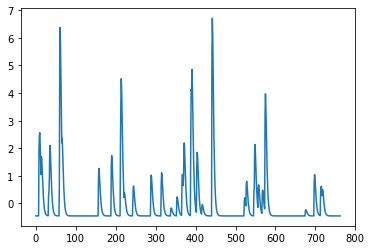

In [77]:
plt.plot(c[3])

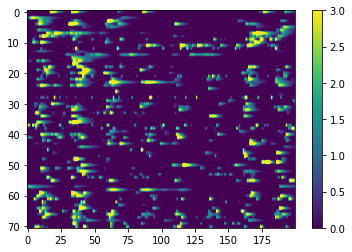

In [82]:
plt.imshow(c[:,0:200], aspect='auto', vmin=0, vmax=3)
plt.colorbar()

In [83]:
result.estimates.detrend_df_f()

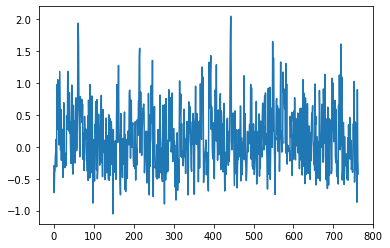

In [84]:
plt.plot(result.estimates.F_dff[3])

In [85]:
f = np.array(result.estimates.F_dff)        
f = f - f.min(axis=1).reshape(-1,1)
f = sklearn.preprocessing.minmax_scale(f, axis=1)

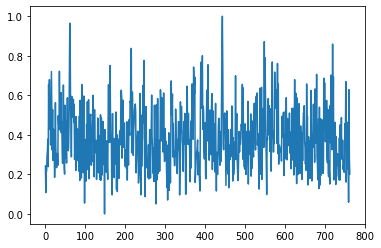

In [86]:
plt.plot(f[3])

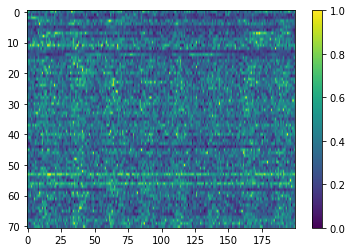

In [87]:
plt.imshow(f[:,0:200], aspect='auto', vmin=0, vmax=1)
plt.colorbar()

In [88]:
motion_worker.mc.

['./tmp_mov_mot_corr.hdf5']